In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

In [2]:
from src.MM_estimation import calc_variance_of_default_rate
from src.MM_estimation import estimate_w_factor_loading
from src.ML_estimation import mle_trapz_g_and_w

In [3]:
df = pd.read_csv('data\SP_historical_PD_data.csv', sep=';')
df["pd_total"] = df["Default rate (%)"] / 100
df["pd_inv"] = df["Investment-grade default rate (%)"] / 100
df["pd_spec"] = df["Speculative-grade default rate (%)"] / 100
# Calculate the number of obligors
df['num_of_inv_grades'] = (df['Investment-grade defaults'] / (df["pd_inv"])).round()
df['num_of_spec_grades'] = (
            df['Speculative-grade defaults'] / (df["pd_spec"])).round().astype(int)
df['num_of_total_grades'] = (df['Total defaults*'] / (df["pd_total"])).round().astype(int)

# Fill-out the missing values in num_of_inv_grades column with the difference between num_of_total_grades and num_of_spec_grades
df['num_of_inv_grades'] = np.where(df['num_of_inv_grades'].isna(), df['num_of_total_grades'] - df['num_of_spec_grades'],
                                   df['num_of_inv_grades']).astype(int)

# MM for speculative grade

In [4]:
# MM for speculative grade
MM_params_spec = estimate_w_factor_loading(df["pd_spec"], df["num_of_spec_grades"], initial_guess=0.3)
print("Estimated parameters for speculative grade: ", MM_params_spec[0], norm.ppf(MM_params_spec[1]))

Estimated parameters for speculative grade:  0.2757333871078777 -1.7498743361043698


# MLE

In [5]:
default_table = df[["Speculative-grade defaults", "Investment-grade defaults"]].values
num_of_obligors = df[["num_of_spec_grades", "num_of_inv_grades"]].values

# ML for speculative grade
ML_params = mle_trapz_g_and_w(default_table, num_of_obligors, [0.27, 0.27], [-2.7, -2.1])

In [6]:
print("Estimated parameters for speculative grade: ", ML_params[0], ML_params[1])

Estimated parameters for speculative grade:  [0.2676783  0.29884413] [-1.7524295  -3.14209441]


# MM for Investment Grade

In [7]:
# MM for investment grade
MM_params_inv = estimate_w_factor_loading(df["pd_inv"], df["num_of_inv_grades"], initial_guess=0.4)
print("Estimated parameters for investment grade: ", MM_params_inv[0], norm.ppf(MM_params_inv[1]))

Estimated parameters for investment grade:  0.2696365259565405 -3.128836387266735


In [8]:
# Calculate the average
pd_average = np.mean(df["pd_inv"])

# Calculate the expected value of 1/n_g
expected_value_of_reciprocal_n_g = np.mean(1 / df["num_of_inv_grades"])

# Variance of default rate
variance_of_p_d = (np.var(df["pd_inv"]) - expected_value_of_reciprocal_n_g * pd_average * (1 - pd_average)) / (
            1 - expected_value_of_reciprocal_n_g)

# Define bounds for w_factor_loading
bounds = [(-0.9999, 0.9999)]

# Define object function
object_function = lambda w: abs(calc_variance_of_default_rate(w, pd_average) - variance_of_p_d)

In [9]:
from scipy.optimize import minimize

result = minimize(object_function, np.array([0.35]), bounds=bounds, tol=1e-6)

result.success, result.x

(True, array([0.34998169]))

In [10]:
from scipy.optimize import minimize

result = minimize(object_function, np.array([0.35]), bounds=bounds, tol=1e-10)

result.success, result.x

(True, array([0.26963651]))

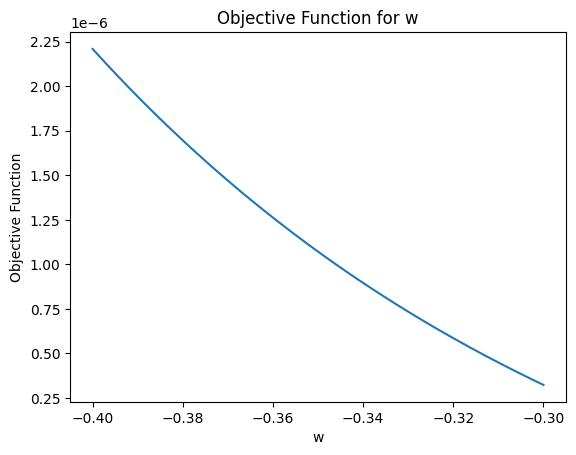

In [11]:
# plot obejct function for w
from matplotlib import pyplot as plt
w_values = np.linspace(-0.4, -0.3, 1000)
object_values = [object_function(w) for w in w_values]

plt.plot(w_values, object_values)
plt.xlabel("w")
plt.ylabel("Objective Function")
plt.title("Objective Function for w")
plt.show()

# To-do monte carlo parameter estimation

# To-do monte carlo likelihood calculation and comparison with calculate_trapz_likelihood_arr 